### 导入所需要的包

In [ ]:
import pandas as pd #pandas 负责操作数据集
import requests #负责下载目录网页
import random #负责生成随机数（似乎并没用，所以为什么要import呢）
from bs4 import BeautifulSoup #bs4，对html文件进行分析
from selenium import webdriver #模拟浏览器进行网页访问
from selenium.webdriver.chrome.options import Options #功能同上，这是浏览器设置
import time #获取当前时间
import re #正则表达式

### 清空数据集 如无必要，不要随便动

In [ ]:
##注意！每次使用当前block会重置数据集，非必要不要取消前两行的注释！
#train_data = pd.DataFrame(columns=['year','title','author','abstract','link','pdf']) 
#train_data.to_csv('AAAI.csv')

### 设置虚拟浏览器
因为AAAI的单论文页面中最主要的部分是在frame标签里，frame即为一个框架，在一个网页里内嵌了另一个网页：
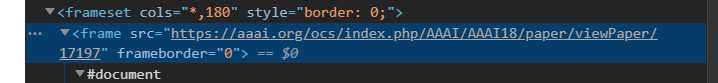
所以事实上不能通过直接分析该网页html文件来确定abstract/author等等。
如果用requests，就必须获取frame的src然后再跳转一个网页去访问，相当于每爬取一篇论文的资源需要访问两次aaai.org,累死。
所以使用虚拟浏览器进行访问，如果不设置无头(--headless)那么它会货真价实地打开一个chrome页面，这里我们使用无头操作，让它的页面在后台操作，这样我们就可以一次获得完整的html数据

In [ ]:
#设置虚拟浏览器。
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
driver = webdriver.Chrome(options=chrome_options)
#driver = webdriver.Chrome()

### 主要的单页面爬虫函数
真正具有爬取功能的函数，操作逻辑如下：
首先分析aaai library的网址：https://aaai.org/Library/AAAI/aaai18contents.php 这是18年的，可以看到是https://aaai.org/Library/AAAI/aaai + 年份的后两位 + contents.php. 所以按照规则去爬取这个主要页面的网址，使用requests即可。
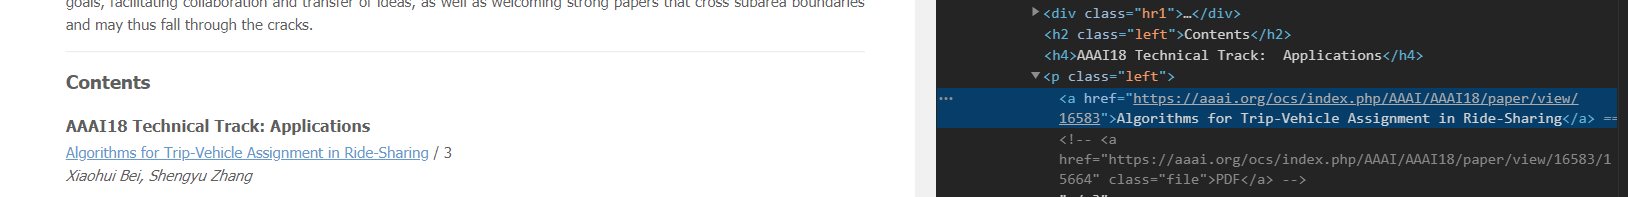
然后看这个链接的格式，发现是http://www.aaai.org/ocs/index.php/AAAI/AAAI + 年份后两位 + /paper/view/ + 一个编号，将其写成正则形式，然后进行匹配，就可以获得论文链接的列表(lists).
然后进行循环访问，这里使用了两层循环，内层循环时对“访问错误的列表”进行访问并爬取，而外层循环则是不断地去尝试错误列表，直到错误列表的长度不断减小直到为0。
在内层循环里，我们使用了try expect机制,理由是为了防止在循环内出错误（比如网络错误）的时候打断整个程序的运行，而只将错误的链接保存下来，留到下次再进行访问，如果我们的外层循环访问了数十次都不能清除这个错误，我们默认这个资源可能有问题，便将其放弃。
同时我们在每一次外层循环开始之前都会读取dataset防止重复录入数据，而在内层循环的一开始，我们只要在已经下载的数据库中发现当前链接便跳过该次循环，而在每一次内层循环结束就将新添加的链接投入数据集（硬盘）免得中途因为某些原因打断了循环导致内存断电或者数据出栈什么都没存下来。
剩下的见注释。

In [ ]:
def spider_AAAI(year):
    html=requests.get('https://www.aaai.org/Library/AAAI/aaai'+str(year)[2:4]+'contents.php')# 下载目录页面html
    pattern = re.compile(r'http://www.aaai.org/ocs/index.php/AAAI/AAAI'+str(year)[2:4]+'/paper/view/[0-9]+')#正则匹配所有论文链接
    result1 = pattern.findall(html.text)#匹配
    lists = list(set(result1))
    wrong = range(len(lists))#将第一次错误列表设置成所有链接
    for the_roll in range(20):
        print('第'+str(year)+'年的第'+str(the_roll)+'次循环') 
        localtime = time.asctime( time.localtime(time.time())) #当前时间
        print(localtime)
        if len(wrong) == 0:
            break;#错误列表为0时直接结束循环
        wrongs = wrong #将错误列表转移，以便接下来往里面重新塞一个列表
        wrong = []
        dataset=pd.read_csv('AAAI.csv') #查重准备
        for i in range(len(wrongs)): #对错误列表的所有元素
            try: #有错误就抛出              
                link = lists[wrongs[i]].replace('\n',''); 
                if dataset[dataset.link == link].notnull()['abstract'].size != 0: #如果在dataset里找到了相同的摘要，那么跳过当前链接
                    continue
                driver.get(link) #使用虚拟浏览器访问当前连接
                iframe = driver.find_elements_by_tag_name("frame")[0] 
                driver.switch_to.frame(iframe)#跳转到frame里
                html = driver.find_element_by_xpath("//*").get_attribute("outerHTML") #获取所有html数据
                soup = BeautifulSoup(html, 'html.parser') #传入soup进行分析
                year = str(year)
                title = ''
                name = ''
                pdf = ''
                abstract = ''
                for people in soup.find_all(id='author'): 
                    name = people.em.text
                for title in soup.find_all(id='title'):
                    title = title.text
                for abstract in soup.find_all(id='abstract'):
                    abstract = abstract.div.text
                for pdfs in soup.find_all(id='paper'):
                    pdf = pdfs.a.get('href')
                #给数据集（dataframe对象，由pandas进行编辑）添加新的一行
                dataset = dataset.append([{'year':year,'title':title,'author':name,'abstract':abstract,'link':link,'pdf':pdf}]) 
                dataset.to_csv('AAAI.csv')#即可写入文件
                print(lists[wrongs[i]].replace('\n','') + ' success!!!   '+'title is '+ title) #成功提示
            except:
                wrong.append(wrongs[i]) #将错误的链接写入失败列表
                print('something went wrong with : ' + lists[wrongs[i]].replace('\n','')) #失败提示
                continue #跳过当前错误

### $都^{TM}给爷爬$

In [ ]:
for i in range(2018,2010,-1): #都给爷爬
    spider_AAAI(i)

#### 可以改进的地方：多线程